In [1]:
import os,librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers as opt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import losses
import pandas as pd
import seaborn as sns

In [2]:
seed=15
n_MFCC=13
column_names= ['MFCC_'+str(i) for i in range(1,n_MFCC+1)]

In [3]:
DATA_PATH="./Vowel_Data/Vowel/"

In [11]:
def get_mfcc(file_path):
    wave, sr= librosa.load(file_path, mono=True, sr=None)
    mfcc=librosa.feature.mfcc(wave,sr=sr,n_mfcc=n_MFCC)
    mfcc_df=pd.DataFrame(mfcc.T,columns=column_names) #convert array to pandas df
    return mfcc_df

def get_all_mfcc(path=DATA_PATH):
    labels=sorted(os.listdir(path))
    all_mfcc=pd.DataFrame() #empty dataframe to store all_mfccs
    
    for label_index,label in enumerate(labels):
        folder_mfcc=pd.DataFrame() #empty dataframe to store mfcc of indivuals vowels/words i.e. folders

        speech_files=[path + label + '/' + file for file in sorted(os.listdir(path+'/'+label))]
        for file in tqdm(speech_files,"Reading Speech of label -'{}'".format(label)):
            #print(file)
            individual_mfcc=get_mfcc(file_path=file)
            folder_mfcc=folder_mfcc.append(individual_mfcc,ignore_index=True)
        
        folder_mfcc['label']=label_index  #new columns for encoding label
        
        all_mfcc=all_mfcc.append(folder_mfcc,ignore_index=True)
        
    return all_mfcc

def get_train_test(split_ratio=0.8,random_state=42):
    all_mfccs=get_all_mfcc()
    
    y=all_mfccs['label'].values
    
    only_mfcc=all_mfccs.drop(labels=['label'],axis=1)
    standard_mfcc=(only_mfcc-only_mfcc.mean())/only_mfcc.std()
    X=standard_mfcc.values

    assert X.shape[0] == len(y)
    return train_test_split(X,y,test_size=(1-split_ratio),random_state=random_state,shuffle=True,stratify=y)

In [12]:
X_train, X_test, y_train, y_test=get_train_test()
y_train_hot=to_categorical(y_train)
y_test_hot=to_categorical(y_test)

Reading Speech of label -'vowel7': 100%|██████████| 40/40 [00:00<00:00, 106.87it/s]


In [13]:
np.random.seed(seed)
model_v=Sequential()
#model_v.add(Dense(128, activation='relu', input_shape=(6,)))
#model_v.add(Dense(64, activation='relu'))
model_v.add(Dense(32, activation='tanh',input_shape=(X_train.shape[1],)))
model_v.add(Dense(16, activation='tanh'))
model_v.add(Dense(7, activation='softmax'))

In [14]:
model_v.compile(
    #optimizer=opt.SGD(learning_rate=0.005,momentum=0.9),
    optimizer=opt.Adam(learning_rate=0.005),
    #loss=losses.CategoricalCrossentropy(),
    loss='categorical_crossentropy',
    #metrics=['AUC'],
    #metrics=['accuracy']#,
    metrics=[['accuracy','AUC']]
)

In [15]:
history_v=model_v.fit(X_train, y_train_hot, epochs=50, batch_size=X_train.shape[0], validation_data=(X_test,y_test_hot))

Epoch 1/50
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
1/1 [==============================] - 0s 435ms/step - loss: 2.0931 - accuracy: 0.1566 - auc: 0.5258 - val_loss: 1.9787 - val_accuracy: 0.1868 - val_auc: 0.5781
Epoch 2/50
1/1 [==============================] - 0s 90ms/step - loss: 1.9709 - accuracy: 0.1931 - auc: 0.5815 - val_loss: 1.8664 - val_accuracy: 0.2211 - val_auc: 0.6362
Epoch 3/50
1/1 [==============================] - 0s 75ms/step - loss: 1.8595 - accuracy: 0.2228 - auc: 0.6387 - val_loss: 1.7653 - val_accuracy: 0.2532 - val_auc: 0.6911
Epoch 4/50
1/1 [==============================] - 0s 70ms/step - loss: 1.7588 - accuracy: 0.2590 - auc: 0.6933 - val_loss: 1.6751 - val_accuracy: 0.2979 - val_auc: 0.7392
Epoch 5/50
1/1 [==============================] - 0s 75ms/step - loss: 1.6687 - accuracy: 0.3003 - auc: 0.7416 - val_loss: 1.5949 - val_accuracy: 0.3316 - val_auc: 0.7791
Epoch 6/50
1/1 [==============================] - 0s 82ms/step 

In [16]:
history_dict=history_v.history

loss_v=history_dict['loss']
val_loss_v=history_dict['val_loss']

epochs=range(1,len(loss_v)+1)

acc_v=history_dict['accuracy']
val_acc_v=history_dict['val_accuracy']

auc_v=history_dict['auc']
val_auc_v=history_dict['val_auc']

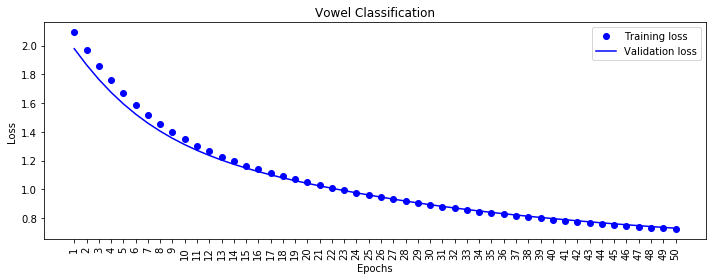

In [58]:
plt.figure(figsize=(10,4))
plt.plot(epochs,loss_v,'bo',label='Training loss')
plt.plot(epochs,val_loss_v,'b',label='Validation loss')
plt.xticks(epochs,rotation=90)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Vowel Classification')
plt.legend()
plt.tight_layout()
plt.savefig('./New_without_CNN/loss_vowel_'+save_specifier+'.pdf',format='pdf', dpi=600)

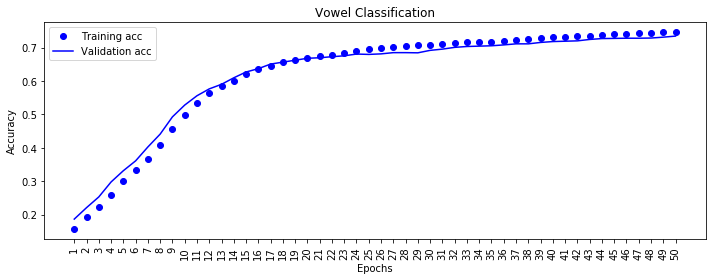

In [57]:
plt.figure(figsize=(10,4))
plt.plot(epochs,acc_v,'bo',label='Training acc')
plt.plot(epochs,val_acc_v,'b',label='Validation acc')
plt.xticks(epochs,rotation=90)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Vowel Classification')
plt.legend()
plt.tight_layout()
plt.savefig('./New_without_CNN/accuracy_vowel_'+save_specifier+'.pdf',format='pdf', dpi=600)

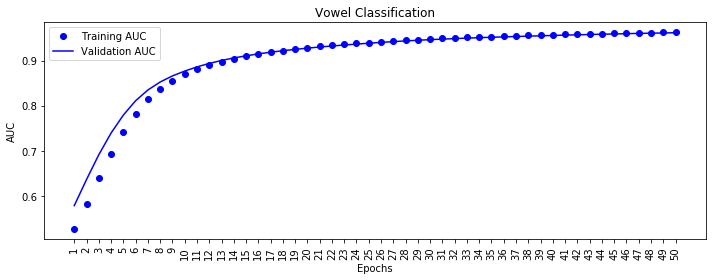

In [56]:
plt.figure(figsize=(10,4))
plt.plot(epochs,auc_v,'bo',label='Training AUC')
plt.plot(epochs,val_auc_v,'b',label='Validation AUC')
plt.xticks(epochs,rotation=90)
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Vowel Classification')
plt.legend()
plt.tight_layout()
plt.savefig('./New_without_CNN/AUC_vowel_'+save_specifier+'.pdf',format='pdf', dpi=600)

In [25]:
DATA_PATH="./Word_Data/Word/"

In [26]:
def get_mfcc(file_path):
    wave, sr= librosa.load(file_path, mono=True, sr=None)
    mfcc=librosa.feature.mfcc(wave,sr=sr,n_mfcc=n_MFCC)
    mfcc_df=pd.DataFrame(mfcc.T,columns=column_names) #convert array to pandas df
    return mfcc_df

def get_all_mfcc(path=DATA_PATH):
    labels=sorted(os.listdir(path))
    all_mfcc=pd.DataFrame() #empty dataframe to store all_mfccs
    
    for label_index,label in enumerate(labels):
        folder_mfcc=pd.DataFrame() #empty dataframe to store mfcc of indivuals vowels/words i.e. folders

        speech_files=[path + label + '/' + file for file in sorted(os.listdir(path+'/'+label))]
        for file in tqdm(speech_files,"Reading Speech of label -'{}'".format(label)):
            #print(file)
            individual_mfcc=get_mfcc(file_path=file)
            folder_mfcc=folder_mfcc.append(individual_mfcc,ignore_index=True)
        
        folder_mfcc['label']=label_index  #new columns for encoding label
        
        all_mfcc=all_mfcc.append(folder_mfcc,ignore_index=True)
        
    return all_mfcc

def get_train_test(split_ratio=0.8,random_state=42):
    all_mfccs=get_all_mfcc()
    
    y=all_mfccs['label'].values
    
    only_mfcc=all_mfccs.drop(labels=['label'],axis=1)
    standard_mfcc=(only_mfcc-only_mfcc.mean())/only_mfcc.std()
    X=standard_mfcc.values

    assert X.shape[0] == len(y)
    return train_test_split(X,y,test_size=(1-split_ratio),random_state=random_state,shuffle=True,stratify=y)

In [27]:
X_train, X_test, y_train, y_test=get_train_test()
y_train_hot=to_categorical(y_train)
y_test_hot=to_categorical(y_test)

Reading Speech of label -'Word7': 100%|██████████| 40/40 [00:00<00:00, 114.31it/s]


In [28]:
np.random.seed(seed)
model_w=Sequential()
#model_w.add(Dense(128, activation='tanh', input_shape=(6,)))
#model_w.add(Dense(64, activation='tanh'))
model_w.add(Dense(32, activation='tanh',input_shape=(X_train.shape[1],)))
model_w.add(Dense(16, activation='tanh'))
model_w.add(Dense(7, activation='softmax'))

In [29]:
model_w.compile(
    #optimizer=opt.SGD(learning_rate=0.005,momentum=0.9),
    optimizer=opt.Adam(learning_rate=0.005),
    #loss=losses.CategoricalCrossentropy(),
    loss='categorical_crossentropy',
    #metrics=['AUC'],
    #metrics=['accuracy']#,
    metrics=[['accuracy','AUC']]
)

In [30]:
history_w=model_w.fit(X_train, y_train_hot, epochs=50, batch_size=X_train.shape[0], validation_data=(X_test,y_test_hot))

Epoch 1/50
1/1 [==============================] - 0s 332ms/step - loss: 1.9930 - accuracy: 0.1671 - auc: 0.5217 - val_loss: 1.9290 - val_accuracy: 0.2057 - val_auc: 0.5723
Epoch 2/50
1/1 [==============================] - 0s 85ms/step - loss: 1.9302 - accuracy: 0.1946 - auc: 0.5724 - val_loss: 1.8725 - val_accuracy: 0.2330 - val_auc: 0.6255
Epoch 3/50
1/1 [==============================] - 0s 104ms/step - loss: 1.8739 - accuracy: 0.2257 - auc: 0.6244 - val_loss: 1.8220 - val_accuracy: 0.2686 - val_auc: 0.6714
Epoch 4/50
1/1 [==============================] - 0s 89ms/step - loss: 1.8234 - accuracy: 0.2566 - auc: 0.6694 - val_loss: 1.7768 - val_accuracy: 0.2947 - val_auc: 0.7060
Epoch 5/50
1/1 [==============================] - 0s 82ms/step - loss: 1.7780 - accuracy: 0.2839 - auc: 0.7045 - val_loss: 1.7362 - val_accuracy: 0.3240 - val_auc: 0.7308
Epoch 6/50
1/1 [==============================] - 0s 110ms/step - loss: 1.7370 - accuracy: 0.3103 - auc: 0.7300 - val_loss: 1.6997 - val_accura

In [31]:
history_dict=history_w.history
loss_w=history_dict['loss']
val_loss_w=history_dict['val_loss']

acc_w=history_dict['accuracy']
val_acc_w=history_dict['val_accuracy']

auc_w=history_dict['auc']
val_auc_w=history_dict['val_auc']

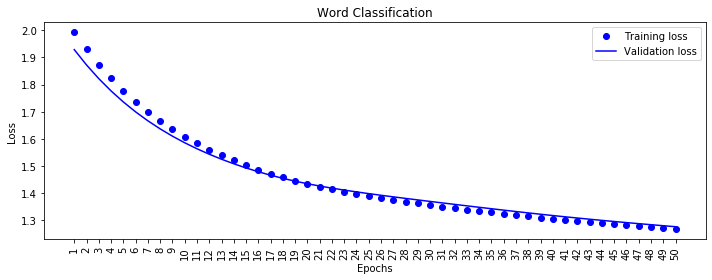

In [55]:
plt.figure(figsize=(10,4))
plt.plot(epochs,loss_w,'bo',label='Training loss')
plt.plot(epochs,val_loss_w,'b',label='Validation loss')
plt.xticks(epochs,rotation=90)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Word Classification')
plt.legend()
plt.tight_layout()
plt.savefig('./New_without_CNN/loss_word_'+save_specifier+'.pdf',format='pdf', dpi=600)

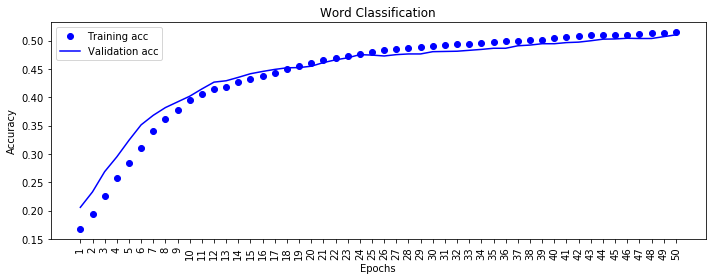

In [54]:
plt.figure(figsize=(10,4))
plt.plot(epochs,acc_w,'bo',label='Training acc')
plt.plot(epochs,val_acc_w,'b',label='Validation acc')
plt.xticks(epochs,rotation=90)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Word Classification')
plt.legend()
plt.tight_layout()
plt.savefig('./New_without_CNN/accuracy_word_'+save_specifier+'.pdf',format='pdf', dpi=600)

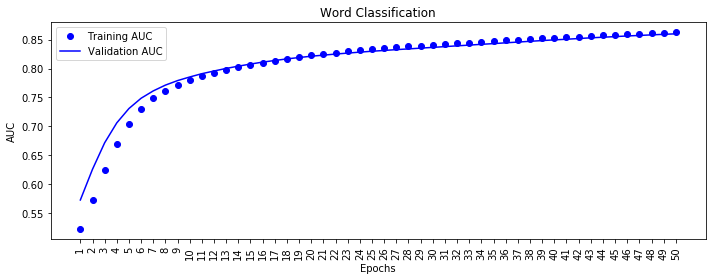

In [53]:
plt.figure(figsize=(10,4))
plt.plot(epochs,auc_w,'bo',label='Training AUC')
plt.plot(epochs,val_auc_w,'b',label='Validation AUC')
plt.xticks(epochs,rotation=90)
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Word Classification')
plt.legend()
plt.tight_layout()
plt.savefig('./New_without_CNN/AUC_word_'+save_specifier+'.pdf',format='pdf', dpi=600)

In [57]:
#COMPARE

In [21]:
save_specifier='standard_mfcc_32_16_tanh_softmax_adam_0.005_batchfull'

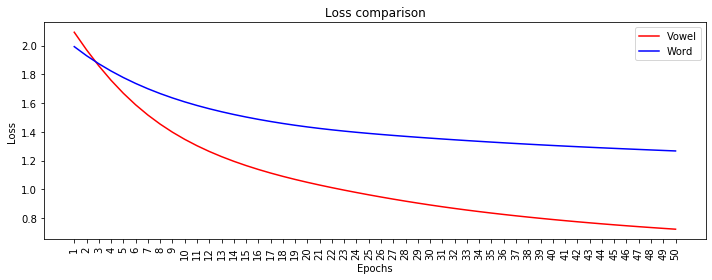

In [61]:
#sns.reset()
#sns.reset_orig()
plt.figure(figsize=(10,4))
plt.plot(epochs,loss_v,'r',label='Vowel')
plt.plot(epochs,loss_w,'b',label='Word')
plt.title('Loss comparison')
plt.xticks(epochs,rotation=90)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('./New_without_CNN/loss_compare_'+save_specifier+'.pdf',format='pdf',dpi=600)

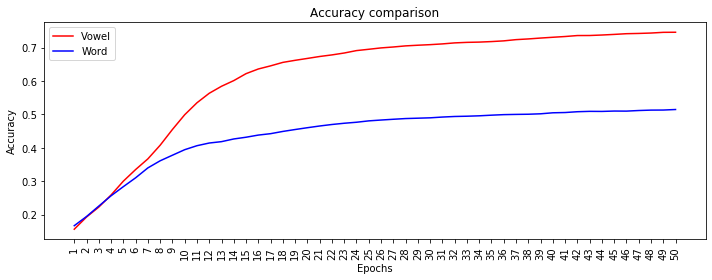

In [60]:
plt.figure(figsize=(10,4))
plt.plot(epochs,acc_v,'r',label='Vowel')
plt.plot(epochs,acc_w,'b',label='Word')
plt.title('Accuracy comparison')
plt.xticks(epochs,rotation=90)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('./New_without_CNN/accuracy_compare_'+save_specifier+'.pdf',format='pdf',dpi=600)

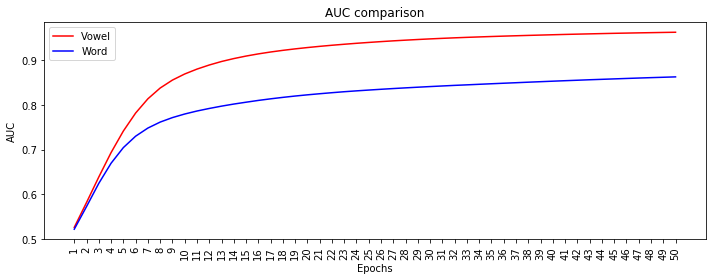

In [59]:
plt.figure(figsize=(10,4))
plt.plot(epochs,auc_v,'r',label='Vowel')
plt.plot(epochs,auc_w,'b',label='Word')
plt.title('AUC comparison')
plt.xticks(epochs,rotation=90)
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.tight_layout()
plt.savefig('./New_without_CNN/AUC_compare_'+save_specifier+'.pdf',format='pdf',dpi=600)

In [44]:
all_compare_df=pd.DataFrame({'loss_v':loss_v,
                      'val_loss_v':val_loss_v,
                      'acc_v':acc_v,
                      'val_acc_v':val_acc_v,
                      'auc_v':auc_v,
                      'val_auc_v':val_auc_v,
                      'loss_w':loss_w,
                      'val_loss_w':val_loss_w,
                      'acc_w':acc_w,
                      'val_acc_w':val_acc_w,
                      'auc_w':auc_w,
                      'val_auc_w':val_auc_w
                     })

all_compare_df.to_csv('./New_without_CNN/all_compare_data_'+save_specifier+'.csv')